In [1]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(6)
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from scipy import ndimage
from scipy.interpolate import LinearNDInterpolator

from preprocessing import *

In [2]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, metadata, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.metadata = metadata

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        objid = self.metadata.OBJID[idx]
        
        sample = {'image': image, 'label': label, 'objid': objid}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label, objid = sample['image'], sample['label'], sample['objid']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label),
                'objid': torch.from_numpy(np.asarray(objid))}

In [3]:
def CatalogMatching(images, labels, metadata):
    # read in LightCurvesRealCoords.csv
    snid_coords = pd.read_csv('LightCurvesRealCoords.csv')
    # assume metadata is stored in "md_df"
    md_df = metadata.merge(snid_coords, on='SNID', how='inner')
    # Load in catalog
    catalog_df = pd.read_csv('DES_Star_Catalog_SOF.csv')
    # Use astropy
    catalog_coords = SkyCoord(ra= catalog_df['STAR_RA'].values*u.degree, dec= catalog_df['STAR_DEC'].values * u.degree)
    candidate_coords = SkyCoord(ra= md_df['RA'].values*u.degree, dec= md_df['DEC'].values * u.degree)
    idx, d2d, d3d = match_coordinates_sky(candidate_coords, catalog_coords)
    #https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html#astropy.coordinates.match_coordinates_sky
    # filter results
    threshold = 1 # in arcsec
    arc_sec_mask = (d2d > threshold * u.arcsec)
    md_indices = np.arange(len(md_df), dtype=int)
    keep_indices = md_indices[arc_sec_mask]
    md_objects_passing_catalog_match = md_df.loc[keep_indices]
    #apply to images
    return images[keep_indices], labels[keep_indices], md_objects_passing_catalog_match.reset_index(drop=True)

In [4]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0, mdtrain0_0, mdtest0_0 = TrainTest('TS__2020-11-25_19-38-15/Class_0_images.h5','TS__2020-11-25_19-38-15/Class_0_metadata.csv',50,100,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2, mdtrain0_2, mdtest0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5','Real__20-07-11_21-31-43/s200224ca_metadata.csv',50,100,0)

mdtrain0_2['ACTION'] = ['Good' for i in range(len(mdtrain0_2))]
mdtest0_2['ACTION'] = ['Good' for i in range(len(mdtest0_2))]

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
mdtrain0, mdtest0 = pd.concat([mdtrain0_0,mdtrain0_2]), pd.concat([mdtest0_0,mdtest0_2])
images_0 = np.concatenate((X_train0_0,X_train0_2,X_test0_0,X_test0_2))
y_0 = np.concatenate((y_train0_0, y_train0_2, y_test0_0, y_test0_2))
md_0 = pd.concat([mdtrain0,mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('TS__2020-11-25_19-38-15/Class_1_images.h5','TS__2020-11-25_19-38-15/Class_1_metadata.csv',500,1000,0)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('TS__2020-11-25_19-38-15/Class_3_images.h5','TS__2020-11-25_19-38-15/Class_3_metadata.csv',400,600,1)
images_3 = np.concatenate((X_train3, X_test3))
y_3 = np.concatenate((y_train3, y_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('TS__2020-11-25_19-38-15/Class_4_images.h5','TS__2020-11-25_19-38-15/Class_4_metadata.csv',274,363,0)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])

X_train5, X_test5, y_train5, y_test5, mdtrain5, mdtest5 = TrainTest('TS__2020-11-25_19-38-15/Class_5_images.h5','TS__2020-11-25_19-38-15/Class_5_metadata.csv',274,368,0)
images_5 = np.concatenate((X_train5, X_test5))
y_5 = np.concatenate((y_train5, y_test5))
md_5 = pd.concat([mdtrain5, mdtest5])

X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('TS__2020-11-25_19-38-15/Class_6_images.h5','TS__2020-11-25_19-38-15/Class_6_metadata.csv',362,1100,0)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [5]:
class0_centers = CenterFlux(images_0,md_0)
class1_centers = CenterFlux(images_1,md_1)
class3_centers = CenterFlux(images_3,md_3)
class4_centers = CenterFlux(images_4,md_4)
class5_centers = CenterFlux(images_5,md_5)
class6_centers = CenterFlux(images_6,md_6)
good_centers = np.concatenate((class0_centers, class1_centers, class3_centers, class6_centers))
notgood_centers = np.concatenate((class4_centers, class5_centers))
md_good = pd.concat([md_0, md_1, md_3, md_6], ignore_index=True)
md_notgood = pd.concat([md_4,md_5], ignore_index=True)
purity_centers, completeness_centers = [], []
thresholds = np.linspace(np.concatenate((good_centers, notgood_centers)).min(), 
                         np.concatenate((good_centers, notgood_centers)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(good_centers > threshold)
    fn = np.sum(good_centers < threshold)
    fp = np.sum(notgood_centers > threshold)
    purity_centers.append(tp / (tp + fp))
    completeness_centers.append(tp / (tp + fn))
desired_completeness = 0.99
center_thres = thresholds[np.argmin(np.abs(np.array(completeness_centers) - desired_completeness))]


thresgood_snr = SNR(md_good.loc[np.where(good_centers > center_thres)[0]])
thresbad_snr = SNR(md_notgood.loc[np.where(notgood_centers > center_thres)[0]])
purity_snr, completeness_snr = [], []
thresholds = np.linspace(np.concatenate((thresbad_snr, thresgood_snr)).min(), 
                         np.concatenate((thresbad_snr, thresgood_snr)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(thresgood_snr > threshold)
    fn = np.sum(thresgood_snr < threshold)
    fp = np.sum(thresbad_snr > threshold)
    purity_snr.append(tp / (tp + fp))
    completeness_snr.append(tp / (tp + fn))
desired_completeness = 0.99
snr_thres = thresholds[np.argmin(np.abs(np.array(completeness_snr) - desired_completeness))]

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


In [6]:
X_train, X_test = np.concatenate((X_train0,X_train3)), np.concatenate((X_test0,X_test3))
y_train, y_test = np.concatenate((y_train0,y_train3)), np.concatenate((y_test0,y_test3))
md_train, md_test = pd.concat([mdtrain0,mdtrain3], ignore_index=True), pd.concat([mdtest0,mdtest3], ignore_index=True)

In [7]:
train_centers = CenterFlux(X_train, md_train)
test_centers = CenterFlux(X_test, md_test)

train_snr = SNR(md_train.loc[np.where(train_centers > center_thres)[0]])
test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_train_centers = md_train.loc[np.where(train_centers > center_thres)[0]].reset_index(drop=True)
md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_train_filtered = md_train_centers.loc[np.where(train_snr > snr_thres)[0]]
md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

train_remaining_indices = md_train[['OBJID']].merge(md_train_filtered, on='OBJID', how='inner', right_index=True).index
test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_train = X_train[train_remaining_indices]
X_test = X_test[test_remaining_indices]
y_train = y_train[train_remaining_indices]
y_test = y_test[test_remaining_indices]
md_train = md_train_filtered.reset_index(drop=True)
md_test = md_test_filtered.reset_index(drop=True)

X_train, y_train, md_train = CatalogMatching(X_train, y_train, md_train)
X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

X_train_unmasked = X_train[~find_masks(X_train)]
y_train_unmasked = y_train[~find_masks(X_train)]
md_train_unmasked = md_train.loc[~find_masks(X_train)].reset_index(drop=True)
X_test_unmasked = X_test[~find_masks(X_test)]
y_test_unmasked = y_test[~find_masks(X_test)]
md_test_unmasked = md_test.loc[~find_masks(X_test)].reset_index(drop=True)

In [8]:
X_train0_sims, X_test0_sims, y_train0_sims, y_test0_sims, mdtrain0_sims, mdtest0_sims = TrainTest('good_simulated_images.h5','good_simulated_metadata.csv',150,300,0)

X_train, X_test = np.concatenate((X_train_unmasked,X_train0_sims)), np.concatenate((X_test_unmasked,X_test0_sims))
y_train, y_test = np.concatenate((y_train_unmasked,y_train0_sims)), np.concatenate((y_test_unmasked,y_test0_sims))
md_train, md_test = pd.concat([md_train_unmasked,mdtrain0_sims], ignore_index=True), pd.concat([md_test_unmasked,mdtest0_sims], ignore_index=True)

In [9]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]

In [10]:
def make_datasets(X_train, y_train, X_test, y_test, md_train, md_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, md_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)

        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=128,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=107648, 
                             out_features=328)
        
        self.fc2 = nn.Linear(in_features=328, 
                             out_features=18)
        
        self.fc3 = nn.Linear(in_features=18, 
                             out_features=2)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    
cnn = CNN()

In [12]:
def train_cnn(cnn, train_dataloader, train_dataset, test_dataset, validation_size=None, monitor=False):
    
    number_of_training_epochs = 10
    if validation_size is None:
        validation_size=len(test_dataset)
    loss_function = nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    
    losses, train_acc, validation_acc = [], [], []

    for epoch in range(number_of_training_epochs):
        sys.stdout.write("\rEpoch {0}\r".format(epoch + 1))
        sys.stdout.flush()

        for i_batch, sample_batched in enumerate(train_dataloader):

            #Clear out all existing gradients on the loss surface to reevaluate for this step
            optimizer.zero_grad()

            #Get the CNN's current prediction of the training data
            output = cnn(sample_batched['image'])

            #Calculate the loss by comparing the prediction to the truth
            loss = loss_function(output, sample_batched['label']) 

            #Evaluate all gradients along the loss surface using back propagation
            loss.backward()

            #Based on the gradients, take the optimal step in the weight space
            optimizer.step()

            #Performance monitoring if desired
            if monitor:
                if i_batch % 10 == 0:
                    train_output = cnn(train_dataset[0:validation_size]['image'])
                    validation_output = cnn(test_dataset[0:validation_size]['image'])

                    train_predictions = torch.max(train_output, 1)[1].data.numpy()
                    validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

                    train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
                    validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size

                    print("Epoch: {0} Batch: {1}  | Training Accuracy: {2:.3f} -- Validation Accuracy: {3:.3f} -- Loss: {4:.3f}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy, loss.data.numpy()))

                    losses.append(loss.data.numpy())
                    train_acc.append(train_accuracy)
                    validation_acc.append(validation_accuracy)
   
    setattr(cnn, 'losses', losses)
    setattr(cnn, 'train_acc', train_acc)
    setattr(cnn, 'validation_acc', validation_acc)
    
    return cnn



In [13]:
N_FOLDS = 10
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
md = pd.concat((md_train, md_test))
split_idx = np.arange(0, len(X), int(len(X) / N_FOLDS))
X_splits = np.split(X, split_idx)[1:]
y_splits = np.split(y, split_idx)[1:]
md_splits = np.split(md, split_idx)[1:]
output_train_accs = []
output_test_accs = []
output_losses = []

In [14]:
for fold in range(N_FOLDS):
    cnn = CNN()
    if fold == 0:
        X_train = np.concatenate((X_splits[1:]))
        X_test = X_splits[0]
        y_train = np.concatenate((y_splits[1:]))
        y_test = y_splits[0]
        md_train = pd.concat(md_splits[1:]).reset_index(drop=True)
        md_test = md_splits[0].reset_index(drop=True)
    elif fold == N_FOLDS - 1:
        X_train = np.concatenate((X_splits[:-1]))
        X_test = X_splits[-1]
        y_train = np.concatenate((y_splits[:-1]))
        y_test = y_splits[-1]
        md_train = pd.concat(md_splits[:-1]).reset_index(drop=True)
        md_test = md_splits[-1].reset_index(drop=True)
    else:
        X_train = np.concatenate((np.concatenate((X_splits[:fold])),np.concatenate((X_splits[fold + 1:]))))
        X_test = X_splits[fold]
        y_train = np.concatenate((np.concatenate((y_splits[:fold])),np.concatenate((y_splits[fold + 1:]))))
        y_test = y_splits[fold]
        md_train = pd.concat((pd.concat(md_splits[:fold]),pd.concat(md_splits[fold + 1:]))).reset_index(drop=True)
        md_test = md_splits[fold].reset_index(drop=True)
    train_dataset, test_dataset, train_dataloader = make_datasets(X_train, 
                  y_train, X_test,  y_test, md_train, md_test, batch_size=20)
    trained_cnn = train_cnn(cnn, train_dataloader, train_dataset, test_dataset, monitor=True)
    output_train_accs.append(trained_cnn.train_acc)
    output_test_accs.append(trained_cnn.validation_acc)
    output_losses.append(trained_cnn.losses)

Epoch: 1 Batch: 1  | Training Accuracy: 0.371 -- Validation Accuracy: 0.352 -- Loss: 0.696
Epoch: 1 Batch: 11  | Training Accuracy: 0.552 -- Validation Accuracy: 0.610 -- Loss: 0.658
Epoch: 1 Batch: 21  | Training Accuracy: 0.581 -- Validation Accuracy: 0.495 -- Loss: 0.657
Epoch: 1 Batch: 31  | Training Accuracy: 0.600 -- Validation Accuracy: 0.600 -- Loss: 0.688
Epoch: 1 Batch: 41  | Training Accuracy: 0.657 -- Validation Accuracy: 0.657 -- Loss: 0.687
Epoch: 2 Batch: 1  | Training Accuracy: 0.657 -- Validation Accuracy: 0.657 -- Loss: 0.684
Epoch: 2 Batch: 11  | Training Accuracy: 0.657 -- Validation Accuracy: 0.657 -- Loss: 0.698
Epoch: 2 Batch: 21  | Training Accuracy: 0.648 -- Validation Accuracy: 0.657 -- Loss: 0.669
Epoch: 2 Batch: 31  | Training Accuracy: 0.667 -- Validation Accuracy: 0.667 -- Loss: 0.653
Epoch: 2 Batch: 41  | Training Accuracy: 0.667 -- Validation Accuracy: 0.610 -- Loss: 0.639
Epoch: 3 Batch: 1  | Training Accuracy: 0.724 -- Validation Accuracy: 0.714 -- Los

In [15]:
np.save('output_train_accs',np.array(output_train_accs))
np.save('output_test_accs',output_test_accs)
np.save('output_losses',output_losses)

In [10]:
output_train_accs = np.load('output_train_accs.npy', allow_pickle=True)
output_test_accs = np.load('output_test_accs.npy', allow_pickle=True)
output_losses = np.load('output_losses.npy', allow_pickle=True)

In [11]:
train_accs = [[] for i in range(len(output_train_accs[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_train_accs[i]):
        if j < 50:
            train_accs[j].append(x)

In [12]:
test_accs = [[] for i in range(len(output_test_accs[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_test_accs[i]):
        if j < 50:
            test_accs[j].append(x)

In [13]:
losses = [[] for i in range(len(output_losses[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_losses[i]):
        if j < 50:
            losses[j].append(x)

In [16]:
xs = []
train_stds = []
train_means = []
test_stds = []
test_means = []
losses_stds = []
losses_means = []


for i,x in enumerate(train_accs):
    xs.append(i)
    train_means.append(np.mean(train_accs[i]))
    train_stds.append(np.std(train_accs[i])/2)
    test_means.append(np.mean(test_accs[i]))
    test_stds.append(np.std(test_accs[i])/2)
    losses_means.append(np.mean(losses[i]))
    losses_stds.append(np.std(losses[i])/2)
    
    
train_y1 = np.array(train_means) + np.array(train_stds)
train_y2 = np.array(train_means) - np.array(train_stds)

test_y1 = np.array(test_means) + np.array(test_stds)
test_y2 = np.array(test_means) - np.array(test_stds)

losses_y1 = np.array(losses_means) + np.array(losses_stds)
losses_y2 = np.array(losses_means) - np.array(losses_stds)

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_

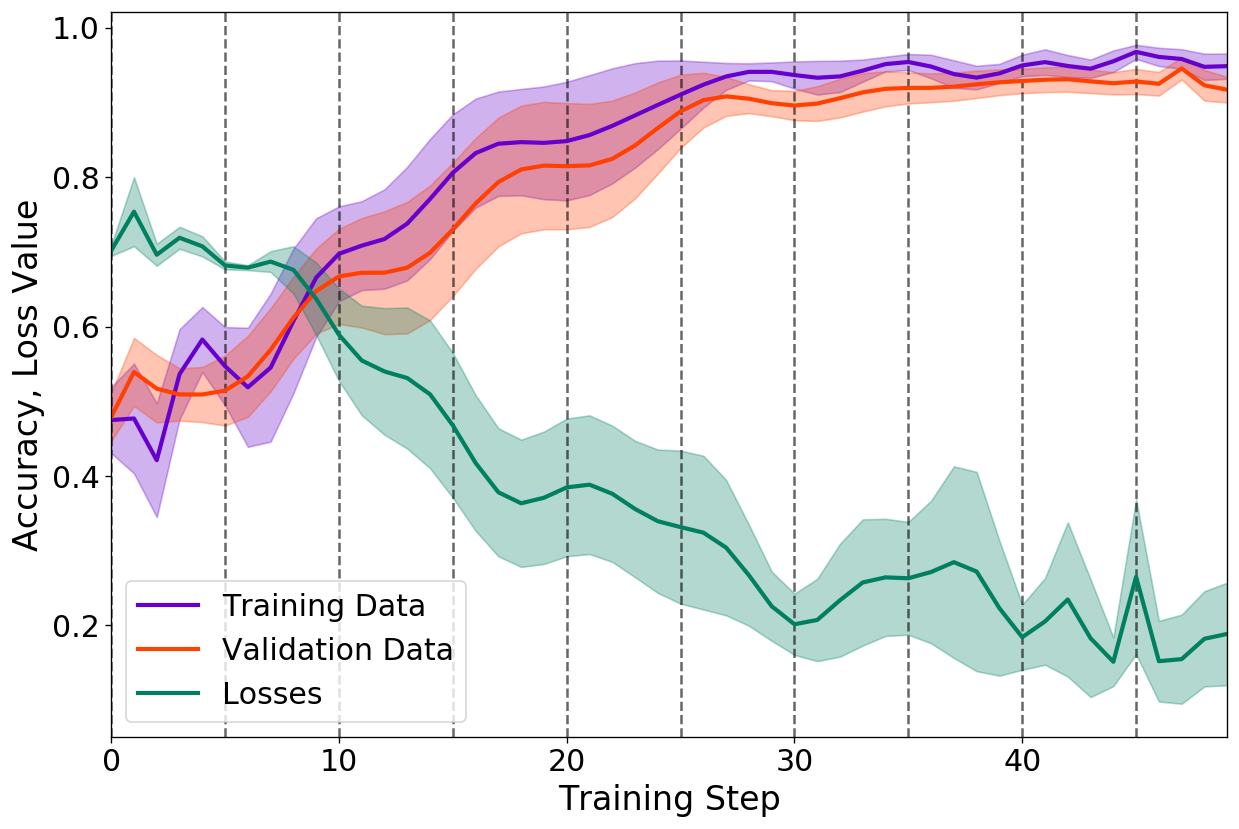

In [20]:
plt.figure(figsize=(12,8), dpi=120)
deg = 40
epochs = [0,5,10,15,20,25,30,35,40,45]
for xc in epochs:
    plt.axvline(x=xc, c='black', linestyle='--',alpha=0.6)
fit_y1 = np.poly1d(np.polyfit(xs, train_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, train_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#6600cc')
train_fit = np.poly1d(np.polyfit(xs, train_means, deg))(xs)
plt.plot(xs, train_fit,label='Training Data',lw=2.5, c='#6600cc')
fit_y1 = np.poly1d(np.polyfit(xs, test_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, test_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#ff4000')
test_fit = np.poly1d(np.polyfit(xs, test_means, deg))(xs)
plt.plot(xs, test_fit,label='Validation Data',lw=2.5, c='#ff4000')
fit_y1 = np.poly1d(np.polyfit(xs, losses_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, losses_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#008060')
losses_fit = np.poly1d(np.polyfit(xs, losses_means, deg))(xs)
plt.plot(xs, losses_fit,label='Losses',lw=2.5, c='#008060')
plt.xlim(0,49)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Training Step',fontsize=20)
plt.ylabel('Accuracy, Loss Value',fontsize=20)
plt.savefig('FirstNetworkTraining.pdf')

In [14]:
X_trainsims, X_testsims, y_trainsims, y_testsims, mdtrainsims, mdtestsims = TrainTest('passed/Class_sims_images.h5','passed/Class_sims_metadata.csv',199,200,0)
images_sims = np.concatenate((X_trainsims, X_testsims))
y_sims = np.concatenate((y_trainsims, y_testsims))
md_sims = pd.concat([mdtrainsims, mdtestsims])

X_train0, X_test0, y_train0, y_test0, mdtrain0, mdtest0 = TrainTest('passed/Class_0_images.h5','passed/Class_0_metadata.csv',200,400,0)
images_0 = np.concatenate((X_train0, X_test0))
y_0 = np.concatenate((y_train0, y_test0))
md_0 = pd.concat([mdtrain0, mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('passed/Class_1_images.h5','passed/Class_1_metadata.csv',250,400,1)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('passed/Class_3_images.h5','passed/Class_3_metadata.csv',70,100,1)
images_3 = np.concatenate((X_train3, X_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('passed/Class_4_images.h5','passed/Class_4_metadata.csv',30,40,1)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])


X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('passed/Class_6_images.h5','passed/Class_6_metadata.csv',250,400,1)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [15]:
X_train, X_test = np.concatenate((X_trainsims,X_train0,X_train1,X_train3,X_train4,X_train6)), np.concatenate((X_testsims,X_test0,X_test1,X_test3,X_test4,X_test6))
y_train, y_test = np.concatenate((y_trainsims,y_train0,y_train1,y_train3,y_train4,y_train6)), np.concatenate((y_testsims,y_test0,y_test1,y_test3,y_test4,y_test6))
md_train, md_test = pd.concat([mdtrainsims,mdtrain0,mdtrain1,mdtrain3,mdtrain4,mdtrain6], ignore_index=True), pd.concat([mdtestsims,mdtest0,mdtest1,mdtest3,mdtest4,mdtest6], ignore_index=True)

In [16]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]
md_train = md_train.iloc[train_idx].reset_index(drop=True)

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [17]:
N_FOLDS = 10
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
md = pd.concat((md_train, md_test))
split_idx = np.arange(0, len(X), int(len(X) / N_FOLDS))
X_splits = np.split(X, split_idx)[1:]
y_splits = np.split(y, split_idx)[1:]
md_splits = np.split(md, split_idx)[1:]
output_train_accs2 = []
output_test_accs2 = []
output_losses2 = []

In [12]:
for fold in range(N_FOLDS):
    cnn = CNN()
    if fold == 0:
        X_train = np.concatenate((X_splits[1:]))
        X_test = X_splits[0]
        y_train = np.concatenate((y_splits[1:]))
        y_test = y_splits[0]
        md_train = pd.concat(md_splits[1:]).reset_index(drop=True)
        md_test = md_splits[0].reset_index(drop=True)
    elif fold == N_FOLDS - 1:
        X_train = np.concatenate((X_splits[:-1]))
        X_test = X_splits[-1]
        y_train = np.concatenate((y_splits[:-1]))
        y_test = y_splits[-1]
        md_train = pd.concat(md_splits[:-1]).reset_index(drop=True)
        md_test = md_splits[-1].reset_index(drop=True)
    else:
        X_train = np.concatenate((np.concatenate((X_splits[:fold])),np.concatenate((X_splits[fold + 1:]))))
        X_test = X_splits[fold]
        y_train = np.concatenate((np.concatenate((y_splits[:fold])),np.concatenate((y_splits[fold + 1:]))))
        y_test = y_splits[fold]
        md_train = pd.concat((pd.concat(md_splits[:fold]),pd.concat(md_splits[fold + 1:]))).reset_index(drop=True)
        md_test = md_splits[fold].reset_index(drop=True)
    train_dataset, test_dataset, train_dataloader = make_datasets(X_train, 
                  y_train, X_test,  y_test, md_train, md_test, batch_size=20)
    trained_cnn = train_cnn(cnn, train_dataloader, train_dataset, test_dataset, monitor=True)
    output_train_accs2.append(trained_cnn.train_acc)
    output_test_accs2.append(trained_cnn.validation_acc)
    output_losses2.append(trained_cnn.losses)

Epoch: 1 Batch: 1  | Training Accuracy: 0.568 -- Validation Accuracy: 0.574 -- Loss: 0.743
Epoch: 1 Batch: 11  | Training Accuracy: 0.426 -- Validation Accuracy: 0.453 -- Loss: 0.754
Epoch: 1 Batch: 21  | Training Accuracy: 0.541 -- Validation Accuracy: 0.486 -- Loss: 0.681
Epoch: 1 Batch: 31  | Training Accuracy: 0.561 -- Validation Accuracy: 0.541 -- Loss: 0.672
Epoch: 1 Batch: 41  | Training Accuracy: 0.554 -- Validation Accuracy: 0.500 -- Loss: 0.700
Epoch: 1 Batch: 51  | Training Accuracy: 0.473 -- Validation Accuracy: 0.500 -- Loss: 0.703
Epoch: 1 Batch: 61  | Training Accuracy: 0.568 -- Validation Accuracy: 0.581 -- Loss: 0.721
Epoch: 2 Batch: 1  | Training Accuracy: 0.561 -- Validation Accuracy: 0.574 -- Loss: 0.733
Epoch: 2 Batch: 11  | Training Accuracy: 0.581 -- Validation Accuracy: 0.568 -- Loss: 0.679
Epoch: 2 Batch: 21  | Training Accuracy: 0.608 -- Validation Accuracy: 0.568 -- Loss: 0.671
Epoch: 2 Batch: 31  | Training Accuracy: 0.635 -- Validation Accuracy: 0.534 -- Lo

In [13]:
np.save('output_train_accs2',np.array(output_train_accs2))
np.save('output_test_accs2',np.array(output_test_accs2))
np.save('output_losses2',np.array(output_losses2))

In [21]:
output_train_accs2 = np.load('output_train_accs2.npy', allow_pickle=True)
output_test_accs2 = np.load('output_test_accs2.npy', allow_pickle=True)
output_losses2 = np.load('output_losses2.npy', allow_pickle=True)

In [22]:
train_accs = [[] for i in range(len(output_train_accs2[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_train_accs2[i]):
        if j < 70:
            train_accs[j].append(x)

test_accs = [[] for i in range(len(output_test_accs2[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_test_accs2[i]):
        if j < 70:
            test_accs[j].append(x)

losses = [[] for i in range(len(output_losses2[0]))]
for i in range(N_FOLDS):
    for j,x in enumerate(output_losses2[i]):
        if j < 70:
            losses[j].append(x)

In [23]:
xs = []
train_stds = []
train_means = []
test_stds = []
test_means = []
losses_stds = []
losses_means = []


for i,x in enumerate(train_accs):
    xs.append(i)
    train_means.append(np.mean(train_accs[i]))
    train_stds.append(np.std(train_accs[i])/2)
    test_means.append(np.mean(test_accs[i]))
    test_stds.append(np.std(test_accs[i])/2)
    losses_means.append(np.mean(losses[i]))
    losses_stds.append(np.std(losses[i])/2)
    
    
train_y1 = np.array(train_means) + np.array(train_stds)
train_y2 = np.array(train_means) - np.array(train_stds)

test_y1 = np.array(test_means) + np.array(test_stds)
test_y2 = np.array(test_means) - np.array(test_stds)

losses_y1 = np.array(losses_means) + np.array(losses_stds)
losses_y2 = np.array(losses_means) - np.array(losses_stds)

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_

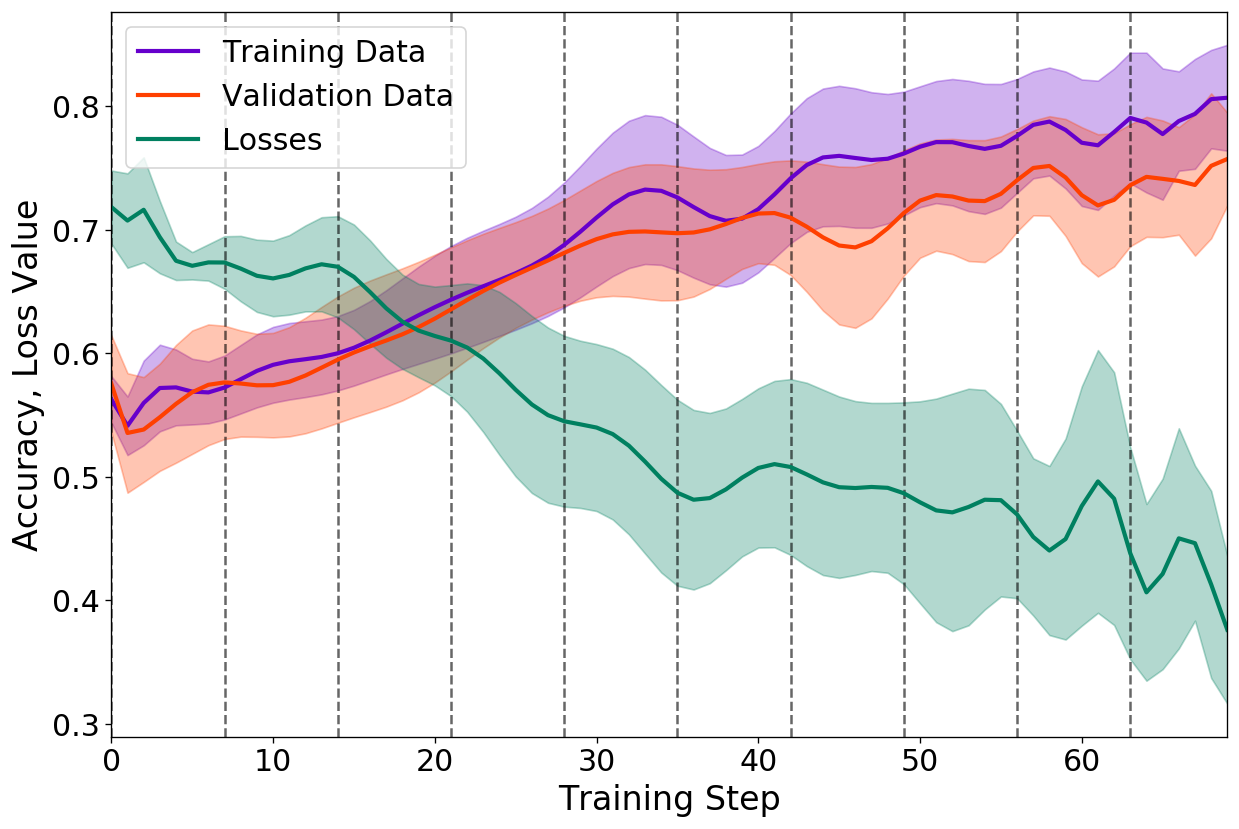

In [25]:
plt.figure(figsize=(12,8), dpi=120)
deg = 40
epochs = [0,7,14,21,28,35,42,49,56,63,70]
for xc in epochs:
    plt.axvline(x=xc, c='black', linestyle='--',alpha=0.6)
fit_y1 = np.poly1d(np.polyfit(xs, train_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, train_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#6600cc')
train_fit = np.poly1d(np.polyfit(xs, train_means, deg))(xs)
plt.plot(xs, train_fit,label='Training Data',lw=2.5, c='#6600cc')
fit_y1 = np.poly1d(np.polyfit(xs, test_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, test_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#ff4000')
test_fit = np.poly1d(np.polyfit(xs, test_means, deg))(xs)
plt.plot(xs, test_fit,label='Validation Data',lw=2.5, c='#ff4000')
fit_y1 = np.poly1d(np.polyfit(xs, losses_y1, deg))(xs)
fit_y2 = np.poly1d(np.polyfit(xs, losses_y2, deg))(xs)
plt.fill_between(xs,fit_y1,fit_y2, alpha=0.3, color='#008060')
losses_fit = np.poly1d(np.polyfit(xs, losses_means, deg))(xs)
plt.plot(xs, losses_fit,label='Losses',lw=2.5, c='#008060')
plt.xlim(0,69)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Training Step',fontsize=20)
plt.ylabel('Accuracy, Loss Value',fontsize=20)
plt.savefig('SecondNetworkTraining.pdf')

In [12]:
X_trainsims, X_testsims, y_trainsims, y_testsims, mdtrainsims, mdtestsims = TrainTest('passed/Class_sims_images.h5','passed/Class_sims_metadata.csv',199,200,0)
images_sims = np.concatenate((X_trainsims, X_testsims))
y_sims = np.concatenate((y_trainsims, y_testsims))
md_sims = pd.concat([mdtrainsims, mdtestsims])

X_train0, X_test0, y_train0, y_test0, mdtrain0, mdtest0 = TrainTest('passed/Class_0_images.h5','passed/Class_0_metadata.csv',200,400,0)
images_0 = np.concatenate((X_train0, X_test0))
y_0 = np.concatenate((y_train0, y_test0))
md_0 = pd.concat([mdtrain0, mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('passed/Class_1_images.h5','passed/Class_1_metadata.csv',250,400,1)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('passed/Class_3_images.h5','passed/Class_3_metadata.csv',70,100,1)
images_3 = np.concatenate((X_train3, X_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('passed/Class_4_images.h5','passed/Class_4_metadata.csv',30,40,1)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])


X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('passed/Class_6_images.h5','passed/Class_6_metadata.csv',250,400,1)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [13]:
X_train, X_test = np.concatenate((X_trainsims,X_train0,X_train1,X_train3,X_train4,X_train6)), np.concatenate((X_testsims,X_test0,X_test1,X_test3,X_test4,X_test6))
y_train, y_test = np.concatenate((y_trainsims,y_train0,y_train1,y_train3,y_train4,y_train6)), np.concatenate((y_testsims,y_test0,y_test1,y_test3,y_test4,y_test6))
md_train, md_test = pd.concat([mdtrainsims,mdtrain0,mdtrain1,mdtrain3,mdtrain4,mdtrain6], ignore_index=True), pd.concat([mdtestsims,mdtest0,mdtest1,mdtest3,mdtest4,mdtest6], ignore_index=True)

In [14]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]
md_train = md_train.iloc[train_idx].reset_index(drop=True)

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [15]:
N_FOLDS = 10
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
md = pd.concat((md_train, md_test))
split_idx = np.arange(0, len(X), int(len(X) / N_FOLDS))
X_splits = np.split(X, split_idx)[1:]
y_splits = np.split(y, split_idx)[1:]
md_splits = np.split(md, split_idx)[1:]
output_train_accs2 = []
output_test_accs2 = []
output_losses2 = []

In [10]:
cnn = CNN()
X_train = np.concatenate((X_splits[1:]))
X_test = X_splits[0]
y_train = np.concatenate((y_splits[1:]))
y_test = y_splits[0]
md_train = pd.concat(md_splits[1:]).reset_index(drop=True)
md_test = md_splits[0].reset_index(drop=True)
        
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test,  
                                                              y_test, md_train, md_test, batch_size=20)
trained_cnn = train_cnn(cnn, train_dataloader, train_dataset, test_dataset, monitor=True)

Epoch: 1 Batch: 1  | Training Accuracy: 0.527 -- Validation Accuracy: 0.446 -- Loss: 0.770
Epoch: 1 Batch: 11  | Training Accuracy: 0.561 -- Validation Accuracy: 0.520 -- Loss: 0.612
Epoch: 1 Batch: 21  | Training Accuracy: 0.608 -- Validation Accuracy: 0.601 -- Loss: 0.650
Epoch: 1 Batch: 31  | Training Accuracy: 0.581 -- Validation Accuracy: 0.541 -- Loss: 0.678
Epoch: 1 Batch: 41  | Training Accuracy: 0.541 -- Validation Accuracy: 0.520 -- Loss: 0.792
Epoch: 1 Batch: 51  | Training Accuracy: 0.622 -- Validation Accuracy: 0.554 -- Loss: 0.703
Epoch: 1 Batch: 61  | Training Accuracy: 0.514 -- Validation Accuracy: 0.574 -- Loss: 0.744
Epoch: 2 Batch: 1  | Training Accuracy: 0.581 -- Validation Accuracy: 0.568 -- Loss: 0.675
Epoch: 2 Batch: 11  | Training Accuracy: 0.514 -- Validation Accuracy: 0.561 -- Loss: 0.642
Epoch: 2 Batch: 21  | Training Accuracy: 0.601 -- Validation Accuracy: 0.561 -- Loss: 0.703
Epoch: 2 Batch: 31  | Training Accuracy: 0.507 -- Validation Accuracy: 0.581 -- Lo

In [11]:
torch.save(cnn.state_dict(), '/home/ashandonay/cosmology/model2_retrained.pt')

In [20]:
X_test = np.concatenate((X_test0,images_1,X_test3,images_4,images_5,images_6))
y_test = np.concatenate((y_test0,y_1,y_test3,y_4,y_5,y_6))
md_test = pd.concat([mdtest0,md_1,mdtest3,md_4,md_5,md_6], ignore_index=True)

In [21]:
test_centers = CenterFlux(X_test, md_test)

test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_test = X_test[test_remaining_indices]
y_test = y_test[test_remaining_indices]
md_test = md_test_filtered.reset_index(drop=True)

X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

X_test_unmasked = X_test[~find_masks(X_test)]
y_test_unmasked = y_test[~find_masks(X_test)]
md_test_unmasked = md_test.loc[~find_masks(X_test)].reset_index(drop=True)

In [22]:
X_test = X_test_unmasked
y_test = y_test_unmasked
md_test = md_test_unmasked

In [23]:
test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [24]:
test_dataset_full = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())

In [25]:
len(test_dataset_full)

2987

In [26]:
validation_probs1 = torch.max(cnn(test_dataset_full[0:1000]['image']), 1)[1].data.numpy()

In [27]:
validation_probs2 = torch.max(cnn(test_dataset_full[1000:2000]['image']), 1)[1].data.numpy()

In [28]:
validation_probs3 = torch.max(cnn(test_dataset_full[2000:3500]['image']), 1)[1].data.numpy()

In [29]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))
md_test = pd.concat([md_test[0:1000],md_test[1000:2000],md_test[2000:3500]]).reset_index()

pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

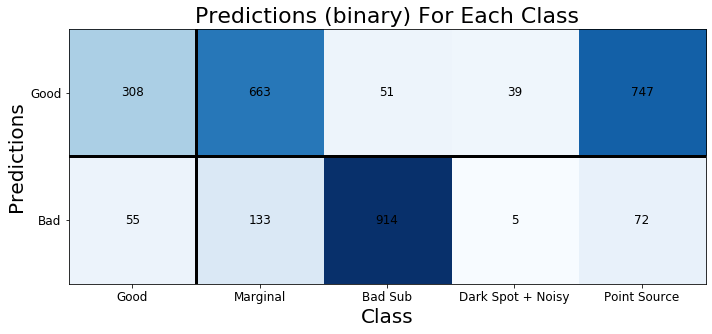

In [30]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()